# Main Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import json # Export dictionary of tuned parameters.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning.
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier, StackingClassifier

from sklearn.base import BaseEstimator, ClassifierMixin


# Evaluation metrics import
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix,
    precision_recall_curve
)

from sklearn.metrics import classification_report

# Models import
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Visualisations import
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn import manifold
from sklearn import discriminant_analysis

# Global variables

# Task 1.1 Exploration

In [ ]:
# Load Data
def load_data(file_path):
    return pd.read_csv(file_path, compression='gzip')

In [ ]:
file_path = "Datasets/data1.csv.gz" 
label_column = "label" 

# Load the dataset
df = load_data(file_path)

In [ ]:
print(df.shape)
df[0:5]

In [ ]:
sparsity_X = (df == 0).mean().iloc[1:]

In [ ]:
fig, ax = plt.subplots()
ax = sns.histplot(data=sparsity_X, kde=True)
fig.suptitle("Fraction of zeros for different features (X).")
ax.set_ylabel("Number of features")
ax.set_xlabel("Fraction of zeros.")
fig.savefig("Figures/t11_sparsity.pdf")
plt.show()

In [ ]:
sum(df.isna().sum())

In [ ]:
df["label"].value_counts()

### PCA for visual analysis

In [ ]:
regressors = df.columns.to_list()
regressors.remove("label")
regressors[0:5] 
X = df[regressors]
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_standardized = scaler.transform(X)
pca = decomposition.PCA(n_components=2)
pca_x_component = pca.fit_transform(X_standardized)
df_pca_x = pd.DataFrame(pca_x_component)
df_pca_x = pd.concat([df['label'],df_pca_x],axis=1)

In [ ]:
sns.jointplot(data=df_pca_x, x=0, y=1, hue="label",height=15)

In [ ]:
pca = decomposition.PCA()
pca_x_component = pca.fit(X_standardized)
pca_x_component.explained_variance_ratio_

In [ ]:
scree_data = pca_x_component.explained_variance_ratio_
scree_data = scree_data.cumsum()

In [ ]:
fig, ax = plt.subplots()      
ax.plot(scree_data)
ax.axhline(scree_data[9], 
           color = 'r', 
           label = f'Variance retained by 10 components: {round(scree_data[9],2)} '
          )
ax.set_ylabel("Total variance retained")
ax.set_xlabel("Number of PCA components")
ax.legend(loc="lower right")
fig.suptitle("Screeplot of PCA components")
fig.savefig("Figures/t11_screeplot.pdf")
plt.show()

In [ ]:
X_embedded = manifold.TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30,random_state=42).fit_transform(X_standardized)
X_tsne = pd.DataFrame(X_embedded)
df_tsne_2 = pd.concat([df['label'],X_tsne],axis=1)

In [ ]:
fig = sns.jointplot(data=df_tsne_2, x=0, y=1, hue="label",height=15).figure
fig.suptitle("Joint density by cell type for t-SNE (2 components)",fontsize=20 ,y = 1.02)
plt.legend( fontsize="20", loc ="upper left")
plt.savefig("Figures/t11_joint_tsne.pdf")
plt.show()

# Task 1.2 Hyperparameter tuning workflow related functions

In [3]:
def plot_confusion_matrix(confusion, labels, title="Confusion Matrix"):
    """
    Plots a heatmap for the given confusion matrix with annotations.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()


In [4]:
def load_data(file_path):
    """
    Load a dataset from a specified file path. Supports gzip-compressed files.
    """
    return pd.read_csv(file_path, compression='gzip')


In [5]:
def train_split(data, label_col, random_state=42, test_size=0.2):
    """
    Splits the dataset into training and testing sets without preprocessing.
    """
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [6]:
class ModelPipeline:
    def __init__(self, model, name, standardize=False, with_pca=False, n_pca_components=10, random_state=42):
        """
        Constructor to initialize the pipeline for a given model.
        - model: The machine learning model (e.g., LDA, RandomForest).
        - name: A unique name for the model.
        - standardize: Whether to apply StandardScaler.
        - with_pca: Whether to include PCA.
        - n_pca_components: Number of PCA components if PCA is used.
        """
        self.model = model
        self.name = name
        self.standardize = standardize
        self.with_pca = with_pca
        self.n_pca_components = n_pca_components
        self.random_state = random_state

        self.pipeline = None
        self.best_params = {}
        self.results = {}  # Store evaluation results for each model

        # Ensure model uses random_state if supported (fixing randomness)
        if "random_state" in self.model.get_params():
            self.model.set_params(random_state=self.random_state)

    def create_pipeline(self):
        """
        Assembles the pipeline steps dynamically based on the configuration:
        - Adds StandardScaler if standardize=True.
        - Adds PCA if with_pca=True.
        - Adds the given model at the end.
        """
        steps = []
        if self.standardize:
            steps.append(('scaler', StandardScaler()))
        if self.with_pca:
            steps.append(('pca', PCA(n_components=self.n_pca_components)))
        steps.append((self.name, self.model))
        self.pipeline = Pipeline(steps)
        # print(f"Pipeline Created: {self.pipeline}")
        return self.pipeline

    def set_params(self, params):
        """
        Updates the parameters of the pipeline.
        - params: Dictionary of parameters to set.
        """
        if not self.pipeline:
            raise ValueError("Pipeline not created. Call create_pipeline() first.")
        self.pipeline.set_params(**params)

    def tune(self, X_train, y_train, param_grid, scoring="f1", cv_folds=5, n_jobs=-1):
        """
        Performs hyperparameter tuning using GridSearchCV.
        - X_train, y_train: Training data and labels.
        - param_grid: Grid of hyperparameters to tune.
        - scoring: base the scoring on the f1 metric
        - cv_folds: Number of cross-validation folds.
        - n_jobs: Number of parallel jobs for GridSearchCV (-1 means maximum possible)
        """
        # Esnsure pipeline is created
        if not self.pipeline:
            self.create_pipeline() 

        # Setup GridSearchCV with the pipeline
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid=param_grid,
            scoring=scoring,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state),
            n_jobs=n_jobs,
            verbose=0
        )


        start_time = time.time() # Track tuning time
        grid_search.fit(X_train, y_train) # Fit the grid search
        elapsed_time = (time.time() - start_time) / 60 # Time in minutes

        # Store the best parameters and save results
        self.best_params = grid_search.best_params_
        self.best_params["MODEL_NAME"] = self.name
        self.best_params["TIME_ELAPSED_MIN"] = elapsed_time

        # Save all results and best parameters
        full_results = pd.DataFrame(grid_search.cv_results_)
        full_results.to_csv(f"Tuning_params/{self.name}_all_results.csv", index=False)
        with open(f"Tuning_params/{self.name}_best_params.json", "w") as f:
            json.dump(self.best_params, f, indent=4)
        print(f"Model {self.name} tuned in {elapsed_time:.2f} minutes") #log running time

    def evaluate(self, X_train, X_test, y_train, y_test):
        """
        Evaluates the performance of the pipeline on test data.
        - X_train, X_test: Training and testing feature matrices.
        - y_train, y_test: Training and testing labels.
        """
        if not self.pipeline:
            self.create_pipeline()

        if self.best_params:
            # Filter only valid pipeline parameters
            valid_params = {
                key: value for key, value in self.best_params.items()
                if key in self.pipeline.get_params()
            }
            print(f"Valid Parameters for Pipeline: {valid_params}")
            self.pipeline.set_params(**valid_params) # Set valid parameters

        # Train the pipeline on training data
        self.pipeline.fit(X_train, y_train)
        # Predict on test data
        y_pred = self.pipeline.predict(X_test)

        # Compute evaluation metrics
        metrics = {
            "Model": self.name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
        }

        # Calculate AUC if available
        if hasattr(self.pipeline, "predict_proba"):
            metrics["AUC"] = roc_auc_score(y_test, self.pipeline.predict_proba(X_test)[:, 1])
        else:
            metrics["AUC"] = None

        # Add confusion matrix (fir plot)
        metrics["Confusion Matrix"] = confusion_matrix(y_test, y_pred).tolist()
        print(f"Evaluation Results: {metrics}")

        # # Save evaluation metrics
        self.results = metrics
        pd.DataFrame([metrics]).to_csv(f"Tuning_params/{self.name}_evaluation_summary.csv", index=False)



In [7]:
def aggregate_results(models):
    """
    Aggregates results from multiple ModelPipeline instances into a single DataFrame (To merge all models' results)
    """
    all_results = [model.results for model in models]
    results_df = pd.DataFrame(all_results)
    results_df.to_csv("Model_Comparison_Results.csv", index=False)
    print("Aggregated results saved to Model_Comparison_Results.csv")
    return results_df


### Loading data

In [8]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Train-Test Split
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)


### LDA Without PCA

In [9]:
lda_model = ModelPipeline(
    model=LinearDiscriminantAnalysis(),
    name="lda",
    standardize=True,
    with_pca=False
)
lda_model.create_pipeline()
lda_grid = [
    {"lda__solver": ["svd"]},
    {"lda__solver": ["lsqr"], "lda__shrinkage": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, "auto"]}
]

In [10]:
lda_model.tune(X_train, y_train, lda_grid)

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model lda tuned in 6.15 minutes


In [11]:
lda_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'lda__shrinkage': 0.8, 'lda__solver': 'lsqr'}
Evaluation Results: {'Model': 'lda', 'Accuracy': 0.965296803652968, 'Balanced Accuracy': 0.95587000064612, 'F1 Score': 0.9511568123393316, 'AUC': 0.9932336872635381, 'Confusion Matrix': [[687, 6], [32, 370]]}


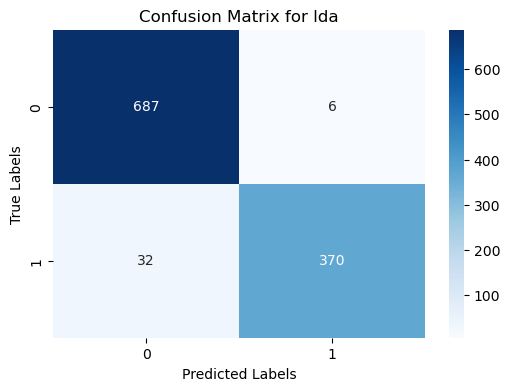

In [12]:
confusion = lda_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {lda_model.name}")

### LDA with PCA (10 components)

In [13]:
lda_pca_model = ModelPipeline(
    model=LinearDiscriminantAnalysis(),
    name="lda_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10
)
lda_pca_model.create_pipeline()
lda_pca_model.set_params({
    f"lda_pca__{key.split('__')[1]}": value for key, value in lda_model.best_params.items() if "__" in key
})


In [14]:
lda_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'lda_pca', 'Accuracy': 0.8776255707762557, 'Balanced Accuracy': 0.8401229781826797, 'F1 Score': 0.8074712643678161, 'AUC': 0.9411635904173217, 'Confusion Matrix': [[680, 13], [121, 281]]}


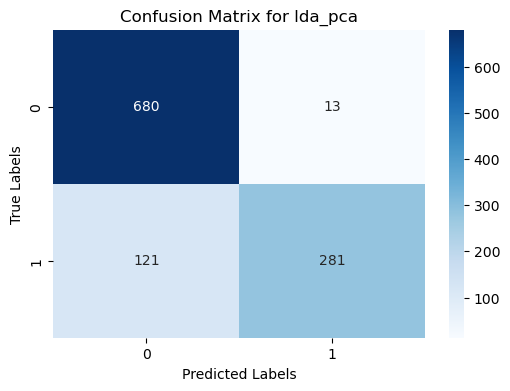

In [15]:
confusion = lda_pca_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {lda_pca_model.name}")

### Tuning Logistic classifier without PCA

In [21]:
# Fixed parameters for logistic regression
logit_fixed_params = {
    "logit__max_iter": 100,
    "logit__solver": "saga",
    "logit__n_jobs": -1,
    "logit__penalty": "elasticnet"
}

logit_grid_params = {
    "logit__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10],
    "logit__l1_ratio": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "logit__class_weight": [None, "balanced"]
}

logit_model = ModelPipeline(
    model=LogisticRegression(),
    name="logit",
    standardize=True,
    with_pca=False
)

logit_model.create_pipeline()
logit_model.set_params(logit_fixed_params)

In [22]:
logit_model.tune(X_train, y_train, logit_grid_params)

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-pack

Model logit tuned in 27.51 minutes


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
logit_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'logit__C': 0.401, 'logit__class_weight': None, 'logit__l1_ratio': 0.7}
Evaluation Results: {'Model': 'logit', 'Accuracy': 0.9579908675799087, 'Balanced Accuracy': 0.9537539574853008, 'F1 Score': 0.9425, 'AUC': 0.9934849561715233, 'Confusion Matrix': [[672, 21], [25, 377]]}


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


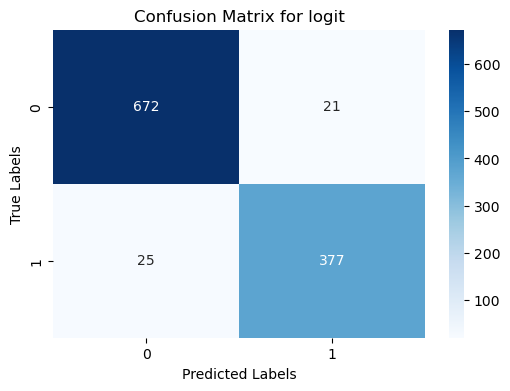

In [24]:
confusion = logit_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {logit_model.name}")

### Tuning logistic classifier with PCA (10 component)

In [25]:
logit_pca_model = ModelPipeline(
    model=LogisticRegression(),
    name="logit_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10
)

logit_pca_model.create_pipeline()

# Combine fixed parameters and best parameters
logit_pca_fixed_and_best_params = {
    **{f"logit_pca__{key.split('__')[1]}": value for key, value in logit_fixed_params.items()},
    **{f"logit_pca__{key.split('__')[1]}": value for key, value in logit_model.best_params.items() if "__" in key}
}

# Apply the combined parameters to the PCA model
logit_pca_model.set_params(logit_pca_fixed_and_best_params)


In [26]:
logit_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'logit_pca', 'Accuracy': 0.960730593607306, 'Balanced Accuracy': 0.9548738989037497, 'F1 Score': 0.9457755359394704, 'AUC': 0.991596849805805, 'Confusion Matrix': [[677, 16], [27, 375]]}


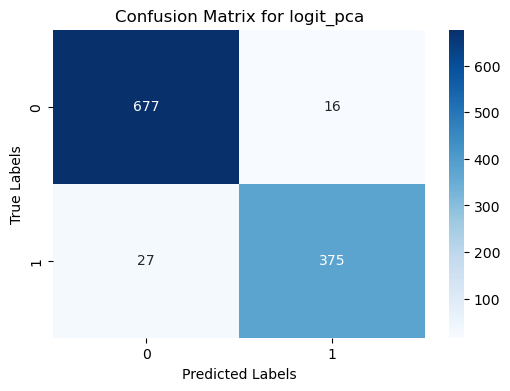

In [27]:
confusion = logit_pca_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {logit_pca_model.name}")

### Tuning QDA without PCA 

In [28]:
qda_model = ModelPipeline(
    model=QuadraticDiscriminantAnalysis(),
    name="qda",
    standardize=True,
    with_pca=False
)
qda_model.create_pipeline()

qda_grid = [
    {
        "qda__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }
]


In [29]:
qda_model.tune(X_train, y_train, qda_grid)

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  war

Model qda tuned in 2.44 minutes


In [30]:
qda_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'qda__reg_param': 0.1}


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Evaluation Results: {'Model': 'qda', 'Accuracy': 0.36712328767123287, 'Balanced Accuracy': 0.5, 'F1 Score': 0.5370741482965932, 'AUC': 0.5, 'Confusion Matrix': [[0, 693], [0, 402]]}


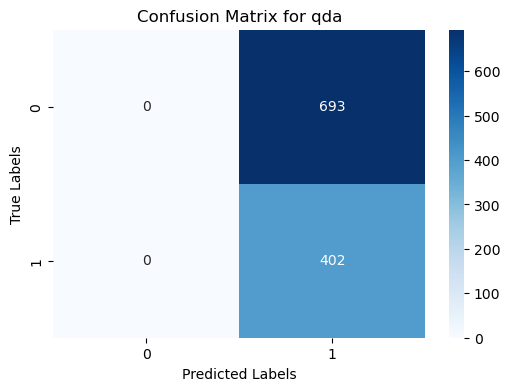

In [31]:
confusion = qda_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {qda_model.name}")

### Tuning QDA with PCA

In [32]:
qda_pca_model = ModelPipeline(
    model=QuadraticDiscriminantAnalysis(),
    name="qda_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10  # Set number of PCA components
)

qda_pca_model.create_pipeline()

qda_pca_model.set_params({
    f"qda_pca__{key.split('__')[1]}": value for key, value in qda_model.best_params.items() if "__" in key
})


In [33]:
qda_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'qda_pca', 'Accuracy': 0.9552511415525115, 'Balanced Accuracy': 0.9484557730826387, 'F1 Score': 0.9380530973451328, 'AUC': 0.9897374598867137, 'Confusion Matrix': [[675, 18], [31, 371]]}


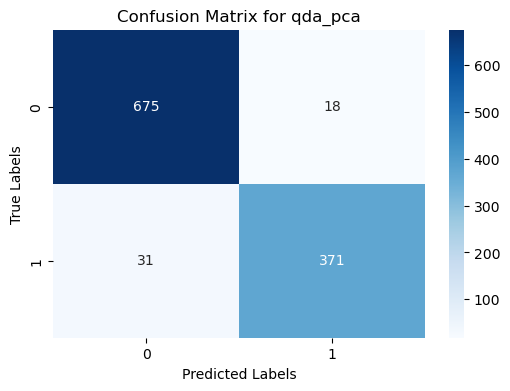

In [34]:
confusion = qda_pca_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test)) 
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {qda_pca_model.name}")

### Tuning K-nn without PCA

In [35]:
# Initialize KNN Model without PCA
knn_model = ModelPipeline(
    model=KNeighborsClassifier(),
    name="knn",
    standardize=True,
    with_pca=False
)

knn_model.create_pipeline()

# Apply fixed parameters
knn_fixed_params = {
    "knn__metric": 'minkowski', 
    "knn__n_jobs": 1
}

knn_grid = [
    {
        "knn__p": [0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 2.2, 3.0, 10.0],
        "knn__weights": ['uniform', 'distance'], 
        "knn__n_neighbors": [1, 3, 5, 9, 11, 15, 20, 30] 
    }
]


knn_model.set_params(knn_fixed_params)


In [ ]:
knn_model.tune(X_train, y_train, knn_grid)

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packag

In [ ]:
knn_model.evaluate(X_train, X_test, y_train, y_test)

In [ ]:
confusion = knn_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))  # Ensure proper labels
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {knn_model.name}")

### Tuning K-nn with PCA

In [ ]:
# Initialize KNN Model with PCA
knn_pca_model = ModelPipeline(
    model=KNeighborsClassifier(),
    name="knn_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10
)

# Create the pipeline
knn_pca_model.create_pipeline()

knn_pca_fixed_and_best_params = {
    **{f"knn_pca__{key.split('__')[1]}": value for key, value in knn_fixed_params.items()},
    **{f"knn_pca__{key.split('__')[1]}": value for key, value in knn_model.best_params.items() if "__" in key}
}

knn_pca_model.set_params(knn_pca_fixed_and_best_params)


In [ ]:
knn_pca_model.evaluate(X_train, X_test, y_train, y_test)

In [ ]:
knn_pca_confusion = knn_pca_model.results["Confusion Matrix"]
knn_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(knn_pca_confusion, knn_pca_labels, title=f"Confusion Matrix for {knn_pca_model.name}")

### Tuning GDBT without PCA

In [ ]:
# Initialize GBDT Model without PCA
gbdt_model = ModelPipeline(
    model=GradientBoostingClassifier(),
    name="gbdt",
    standardize=False,
    with_pca=False
)

# Create the pipeline
gbdt_model.create_pipeline()

# Apply fixed parameters
gbdt_fixed_params = {
    "gbdt__loss": "log_loss",
    "gbdt__n_iter_no_change": 15  # Early stopping to save time
}

# Apply fixed parameters
gbdt_model.set_params(gbdt_fixed_params)

gbdt_grid = [
    {
        "gbdt__n_estimators": [100, 200, 300, 400, 500],  # Number of boosting stages
        "gbdt__max_depth": [1, 3, 5, 7, 9],               # Maximum depth of trees
        "gbdt__learning_rate": [0.1, 0.05, 0.2, 0.3],     # Learning rate (v from the book)
        "gbdt__max_features": ["sqrt", 100, 130]          # Features to consider when looking for the best split
    }
]

In [ ]:
gbdt_model.tune(X_train, y_train, gbdt_grid)

In [ ]:
gbdt_model.evaluate(X_train, X_test, y_train, y_test)

In [ ]:
gbdt_confusion = gbdt_model.results["Confusion Matrix"]
gbdt_labels = sorted(np.unique(y_test))
plot_confusion_matrix(gbdt_confusion, gbdt_labels, title=f"Confusion Matrix for {gbdt_model.name}")

### Tuning GDBT with PCA

In [ ]:
gbdt_pca_model = ModelPipeline(
    model=GradientBoostingClassifier(),
    name="gbdt_pca",
    standardize=False, 
    with_pca=True,
    n_pca_components=10
)

gbdt_pca_model.create_pipeline()

gbdt_pca_fixed_and_best_params = {
    **{f"gbdt_pca__{key.split('__')[1]}": value for key, value in gbdt_fixed_params.items()},
    **{f"gbdt_pca__{key.split('__')[1]}": value for key, value in gbdt_model.best_params.items() if "__" in key}
}

gbdt_pca_model.set_params(gbdt_pca_fixed_and_best_params)


In [ ]:
gbdt_pca_model.evaluate(X_train, X_test, y_train, y_test)

In [ ]:
gbdt_pca_confusion = gbdt_pca_model.results["Confusion Matrix"]
gbdt_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(gbdt_pca_confusion, gbdt_pca_labels, title=f"Confusion Matrix for {gbdt_pca_model.name}")

### Tuning Random Forest without PCA

In [ ]:
# Initialize RF Model without PCA
rf_model = ModelPipeline(
    model=RandomForestClassifier(),
    name="rf",
    standardize=False,
    with_pca=False
)

# Create the pipeline
rf_model.create_pipeline()

rf_fixed_params = {
    "rf__bootstrap": True 
}

rf_model.set_params(rf_fixed_params)

# Define grid search parameters
rf_grid = [
    {
        "rf__n_estimators": [100, 200, 300, 400],    # Number of trees
        "rf__criterion": ["gini", "entropy"],       # Splitting criterion
        "rf__max_features": ["sqrt", "log2"]        # Features to consider at each split
    }
]


In [ ]:
rf_model.tune(X_train, y_train, rf_grid)

In [ ]:
rf_model.evaluate(X_train, X_test, y_train, y_test)

In [ ]:
rf_confusion = rf_model.results["Confusion Matrix"]
rf_labels = sorted(np.unique(y_test))
plot_confusion_matrix(rf_confusion, rf_labels, title=f"Confusion Matrix for {rf_model.name}")

### Tuning Random Forest with PCA

In [ ]:
# Initialize RF Model with PCA
rf_pca_model = ModelPipeline(
    model=RandomForestClassifier(),
    name="rf_pca",
    standardize=False,
    with_pca=True,
    n_pca_components=10
)

rf_pca_model.create_pipeline()

rf_pca_fixed_and_best_params = {
    **{f"rf_pca__{key.split('__')[1]}": value for key, value in rf_fixed_params.items()},
    **{f"rf_pca__{key.split('__')[1]}": value for key, value in rf_model.best_params.items() if "__" in key}
}

rf_pca_model.set_params(rf_pca_fixed_and_best_params)

In [ ]:
rf_pca_model.evaluate(X_train, X_test, y_train, y_test)

In [ ]:
rf_pca_confusion = rf_pca_model.results["Confusion Matrix"]
rf_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(rf_pca_confusion, rf_pca_labels, title=f"Confusion Matrix for {rf_pca_model.name}")

### Tuning SVM without PCA

In [ ]:
# Initialize SVM Model without PCA
svm_model = ModelPipeline(
    model=SVC(),
    name="svm",
    standardize=True,
    with_pca=False
)

# Create the pipeline
svm_model.create_pipeline()

# Apply fixed parameters
svm_fixed_params = {
    "svm__degree": 3  # Degree of the polynomial kernel function
}

# Apply fixed parameters
svm_model.set_params(svm_fixed_params)

# Define grid search parameters
svm_grid = [
    {
        "svm__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10],
        "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "svm__gamma": ["scale", "auto"],
        "svm__class_weight": [None, "balanced"]
    }
]


In [ ]:
svm_model.tune(X_train, y_train, svm_grid)

In [ ]:
svm_model.evaluate(X_train, X_test, y_train, y_test)


In [ ]:
svm_confusion = svm_model.results["Confusion Matrix"]
svm_labels = sorted(np.unique(y_test))
plot_confusion_matrix(svm_confusion, svm_labels, title=f"Confusion Matrix for {svm_model.name}")

### Tuning SVM with PCA

In [ ]:
svm_pca_model = ModelPipeline(
    model=SVC(),
    name="svm_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10
)

svm_pca_model.create_pipeline()

svm_pca_fixed_and_best_params = {
    **{f"svm_pca__{key.split('__')[1]}": value for key, value in svm_fixed_params.items()},
    **{f"svm_pca__{key.split('__')[1]}": value for key, value in svm_model.best_params.items() if "__" in key}
}

svm_pca_model.set_params(svm_pca_fixed_and_best_params)


In [ ]:
svm_pca_model.evaluate(X_train, X_test, y_train, y_test)


In [ ]:
svm_pca_confusion = svm_pca_model.results["Confusion Matrix"]
svm_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(svm_pca_confusion, svm_pca_labels, title=f"Confusion Matrix for {svm_pca_model.name}")

### Final Table for 1.2

In [ ]:
models = [
    lda_model, lda_pca_model,          
    logit_model, logit_pca_model,       
    qda_model, qda_pca_model,          
    knn_model, knn_pca_model,           
    gbdt_model, gbdt_pca_model,         
    rf_model, rf_pca_model,            
    svm_model, svm_pca_model         
]

results_df = aggregate_results(models)

print("Aggregated Results:")
print(results_df)


# Task 1.3 Extra Evaluation

### Adaboost with PCA

In [ ]:
ada_boost_pca_model = ModelPipeline(
    model=AdaBoostClassifier(random_state=42),
    name="ada_boost_pca",
    standardize=True,
    with_pca=True 
)

ada_boost_pca_model.create_pipeline()

ada_boost_fixed_params = {
    "ada_boost_pca__algorithm": "SAMME"
}
ada_boost_pca_model.set_params(ada_boost_fixed_params)

ada_boost_pca_grid = [
    {
        "ada_boost_pca__estimator": [DecisionTreeClassifier(max_depth=2), LogisticRegression()],
        "ada_boost_pca__n_estimators": [50, 100, 200],
        "ada_boost_pca__learning_rate": [0.05, 0.1, 0.5, 1],
        "pca__n_components": [8, 10, 12, 15, 20]  # Tune PCA components
    }
]


In [ ]:
ada_boost_pca_model.tune(X_train, y_train, ada_boost_pca_grid)

In [ ]:
ada_boost_pca_model.evaluate(X_train, X_test, y_train, y_test)

In [ ]:
ada_boost_pca_confusion = ada_boost_pca_model.results["Confusion Matrix"]
ada_boost_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(ada_boost_pca_confusion, ada_boost_pca_labels, title=f"Confusion Matrix for {ada_boost_pca_model.name}")

### Threshhold optimization technique

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt

def optimize_threshold(model, X_val, y_val, metric=f1_score, thresholds=np.linspace(0, 1, 101)):
    """
    Optimizes the decision threshold for a trained model based on a specified metric.
    """
    probs = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
    threshold_scores = {}

    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        score = metric(y_val, y_pred)
        threshold_scores[threshold] = score

    # Find the optimal threshold
    best_threshold = max(threshold_scores, key=threshold_scores.get)
    best_score = threshold_scores[best_threshold]
    return best_threshold, best_score, threshold_scores

def plot_threshold_vs_metric(threshold_scores, best_threshold, best_score, metric_name="F1 Score"):
    """
    Plots the relationship between thresholds and the evaluation metric.
    """
    thresholds = list(threshold_scores.keys())
    scores = list(threshold_scores.values())

    plt.figure(figsize=(7, 5))
    plt.plot(thresholds, scores, label=f"{metric_name} vs. Threshold", marker="o", color="#4e79a7")
    plt.axvline(best_threshold, color="orange", linestyle="--", label=f"Optimal Threshold = {best_threshold:.2f}")
    plt.axhline(best_score, color="green", linestyle="--", label=f"Best {metric_name} = {best_score:.3f}")
    plt.axvline(0.5, color="red", linestyle=":", label="Default Threshold = 0.5")
    plt.title(f"{metric_name} vs. Decision Threshold", fontsize=14)
    plt.xlabel("Decision Threshold", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()


In [ ]:
logit_best_model = logit_model.pipeline

# Optimize Threshold
best_threshold, best_f1, threshold_scores = optimize_threshold(
    model=logit_best_model,
    X_val=X_test,
    y_val=y_test,
    metric=f1_score
)

print(f"Optimal Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")

# Plot Threshold vs Metric
plot_threshold_vs_metric(threshold_scores, best_threshold, best_f1)

# 1.4 Picking the best model and using mypredict()